# Trade for power architectures

In [1]:
import numpy as np
import pykep as pk
from pykep.planet import jpl_lp
from pykep import epoch
import pygmo as pg
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import spiceypy as spice

%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")
import pyxplorer as pxp

In [3]:
SMA_SATURN_AU = 9.573

In [4]:
#mission_time_day = np.linspace(0, 20, 1000)*365

In [12]:
rs = []
depart_duration = 8*365.25
return_duration = 10*365.25
mission_duration = 180  # sample return only

mission_time_day = np.linspace(0, depart_duration+mission_duration+return_duration, 1000)

for mission_time in mission_time_day:
    if mission_time < depart_duration:
        # transfer
        rs.append(1 + mission_time/depart_duration*(SMA_SATURN_AU - 1.0))
    # stay
    elif mission_time < depart_duration + mission_duration:
        # stay
        rs.append(SMA_SATURN_AU)
        
    else:
        # transfer back
        return_time = mission_time - (depart_duration + mission_duration)
        rs.append(SMA_SATURN_AU - return_time/return_duration*(SMA_SATURN_AU - 1.0))

In [13]:
1366 / SMA_SATURN_AU**2

14.905775692365914

In [14]:
cutoff_times = np.array([
    depart_duration,
    depart_duration+mission_duration,
])

In [15]:
# model RTG/SRGs
def compute_power_RG(P_bol, t_year, D_frac_per_year):
    return (1-D_frac_per_year)**t_year * P_bol

In [16]:
# model solar
def compute_power_solar(P_bol_1AU, t_year, D_frac_per_year, radius):
    return (1-D_frac_per_year)**t_year * P_bol_1AU/radius**2

In [17]:
# constants for SRGs
D_SRG = 1.16/100  # fraction/year

# constants for solar array
eta_SA = 0.22
eta_d  = 0.85
sigma  = 2.8
P_bol_1AU = 1366*eta_SA*eta_d/sigma
D_SA = 0.5/100   # fraction/year

solar = []
srg2, srg4, srg6, srg8 = [], [], [], []

for idx, mission_time in enumerate(mission_time_day):
    r = rs[idx]
    # compute solar
    solar.append(
        compute_power_solar(P_bol_1AU, mission_time/365.25, D_SA, r)
    )
    
    # compute SRG power
    srg2.append(
        compute_power_RG(130/17.3, mission_time/365.25, D_SRG)
    )
    srg4.append(
        compute_power_RG(240/32.0, mission_time/365.25, D_SRG)
    )
    srg6.append(
        compute_power_RG(370/46.8, mission_time/365.25, D_SRG)
    )
    srg8.append(
        compute_power_RG(510/64.6, mission_time/365.25, D_SRG)
    )

<IPython.core.display.Javascript object>


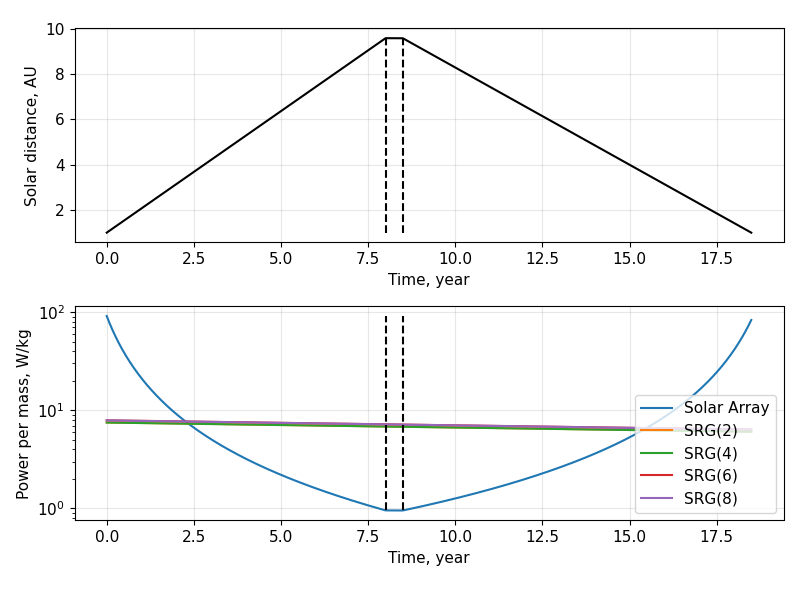

In [18]:
plt.rcParams["font.size"] = 11

fig, axs = plt.subplots(2,1, figsize=(8,6))

axs[0].plot(mission_time_day/365.25, rs, c="black")
axs[0].set(xlabel="Time, year", ylabel="Solar distance, AU")
axs[0].grid(True, alpha=0.3)
axs[0].vlines(cutoff_times/365.25, min(rs), max(rs), color="black", linestyle="--")

axs[1].plot(mission_time_day/365.25, solar, label="Solar Array")
axs[1].plot(mission_time_day/365.25, srg2, label="SRG(2)")
axs[1].plot(mission_time_day/365.25, srg4, label="SRG(4)")
axs[1].plot(mission_time_day/365.25, srg6, label="SRG(6)")
axs[1].plot(mission_time_day/365.25, srg8, label="SRG(8)")
axs[1].set(xlabel="Time, year", ylabel="Power per mass, W/kg")
axs[1].legend(loc="best")
axs[1].grid(True, alpha=0.3)
axs[1].vlines(cutoff_times/365.25, min(solar), max(solar), color="black", linestyle="--")

axs[1].set_yscale('log')

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()

In [19]:
fig.savefig("./plots/power_srg_sa_trade.png")